# Training an allosteric network at nonzero temperature

Begin with a few package imports:

In [1]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt

from packing_utils import *
from allosteric_utils import *
from plot_imports import *
from lammps_utils import *

### Network generation

Load in a saved, untrained network from file:

<IPython.core.display.Javascript object>


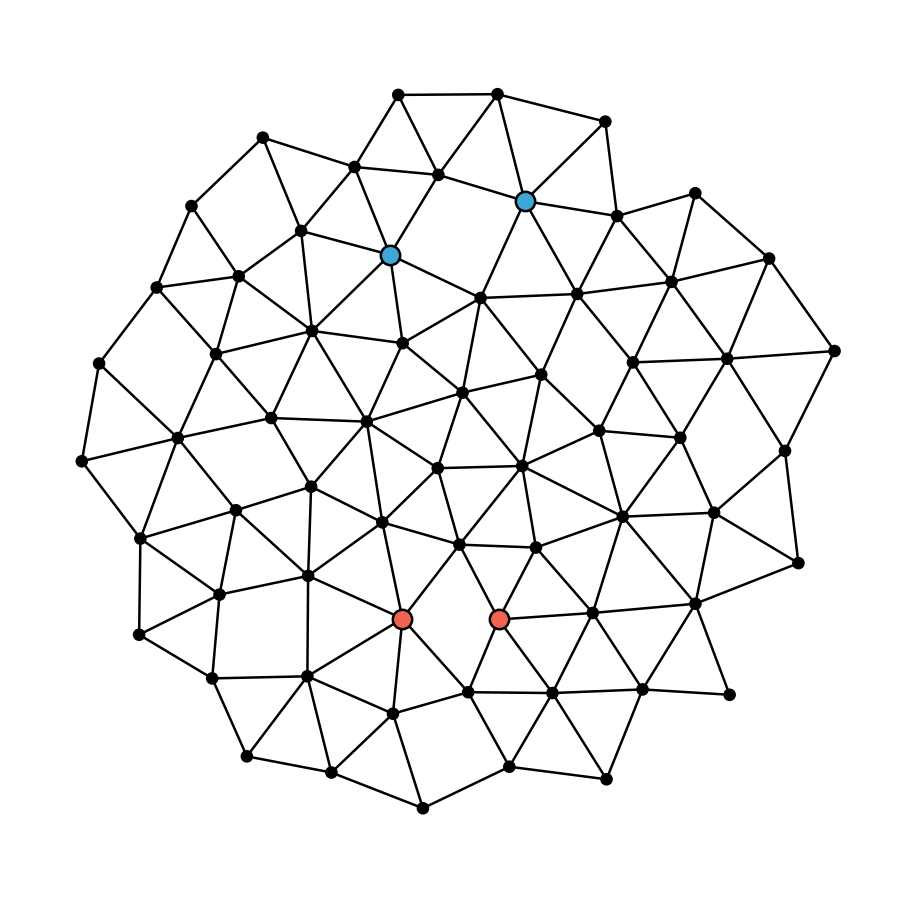

In [2]:
%matplotlib notebook

n = 64
seed = 0
filename = 'allo_{:d}_{:d}.txt'.format(n,seed)

allo = Allosteric(filename, auto=False, seed=seed)
allo.plot()

### Training

Specify a temperature, source and target strain to apply, training time, and training method. Also indicate the path to the LAMMPS executable you have installed.

In [3]:
temp = 1e-8

es = 0.2                # source strain of 20%
et = 0.2                # target strain of 20% applied to all targets
ka = 100.               # stiffness of spring for applied strain
duration = 1e6          # training time
frames = 400            # number of output frames
train = 2               # 1 trains bond rest lengths, 2 trains bond stiffnesses
method = 'learning'     # learning rule to use, 'aging' (directed aging) or 'learning' (coupled learning)

# compute the mean square bond length as a normalization factor
l2 = np.mean([edge[2]['length']**2 for edge in allo.graph.edges(data=True)])

eta = 1e-1              # learning rate
alpha = 1e-2/l2         # aging rate
vmin = 1e-3             # minimum allowed stiffness

# path to LAMMPS executable - replace with your own!
lmp = '/path/to/lmp'

Since the network is untrained, applying a strain at the source (blue curve) produces no initial strain at the target:

progress: 100%|#############################################################9| 1000000.00/1000000.00 [00:03<00:00]


<IPython.core.display.Javascript object>


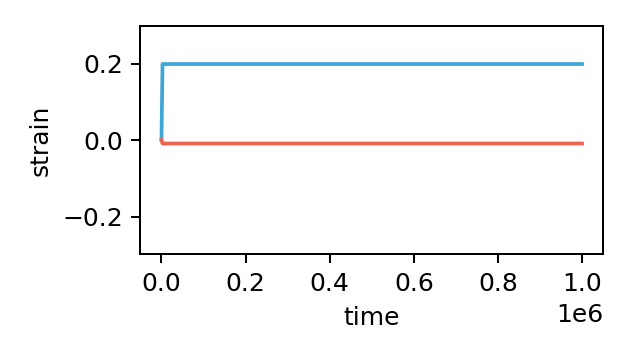

In [4]:
%matplotlib notebook

allo.reset_init()
allo.solve(duration=duration, frames=frames, T=0, applied_args=(es, 0, ka))
allo.strain_plot()

The following function will set up a LAMMPS data and input file from the current network and place them in the specified output directory ```odir```. Here we set ```odir``` to be the current directory.

In [5]:
odir = 'lammps/'          # output directory for LAMMPS files
prefix = 'temp_test'      # prefix used for naming the files

setup_run(allo, odir, prefix, lmp, duration, frames, (es, et, ka),
          train=train, method=method, eta=eta, alpha=alpha, vmin=vmin, temp=temp)

Simulation files written to: lammps/
Navigate to directory and run: /Users/jovanaandrejevic/git/learning/lammps/my_build/lmp -i temp_test.in -log temp_test.log


Once the LAMMPS simulation is finished, we can read out the results:

<IPython.core.display.Javascript object>


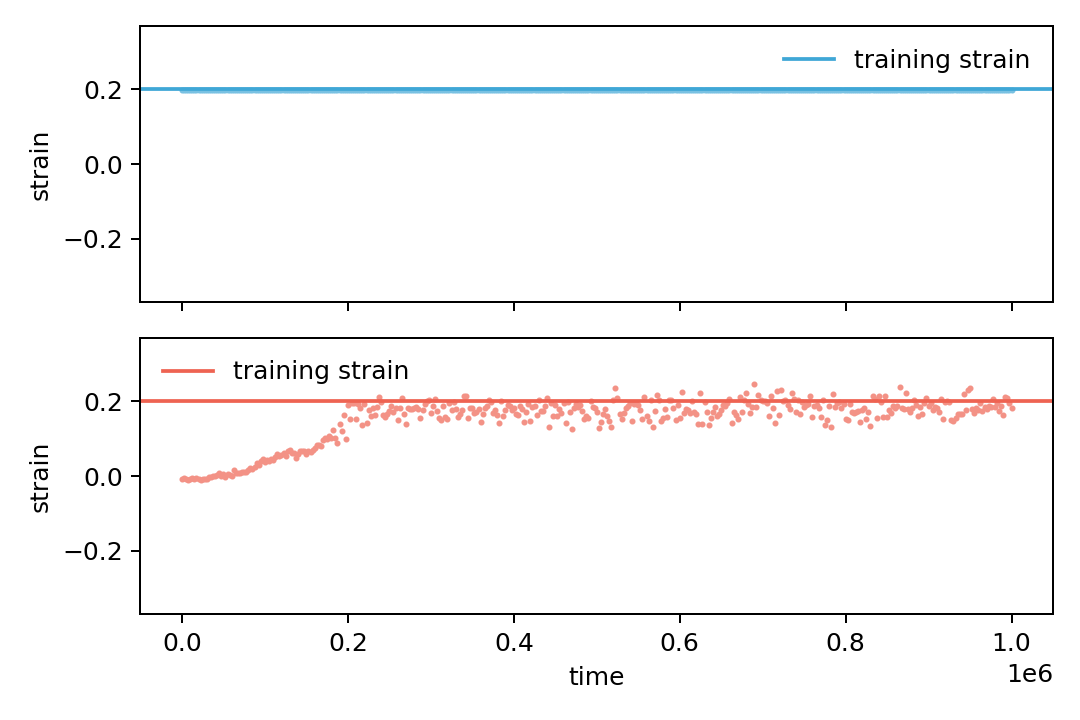

In [6]:
%matplotlib notebook

allo, data, cols = load_run(odir)
allo.strain_plot_thermal(es, et)

### Visualization

View the final distribution of stiffnesses:

<IPython.core.display.Javascript object>


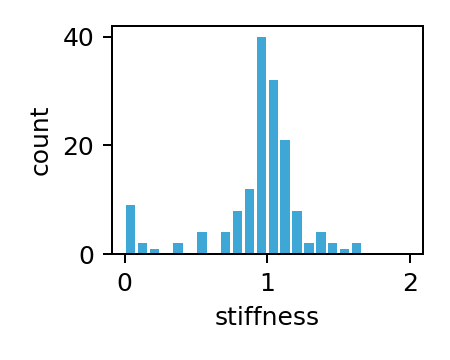

In [7]:
%matplotlib notebook

k = allo.distribution_plot(kind='stiffness', vmin=0, vmax=2, nbins=25)

Also visualize which bonds weakened (reds) and which bonds strengthened (blues):

<IPython.core.display.Javascript object>


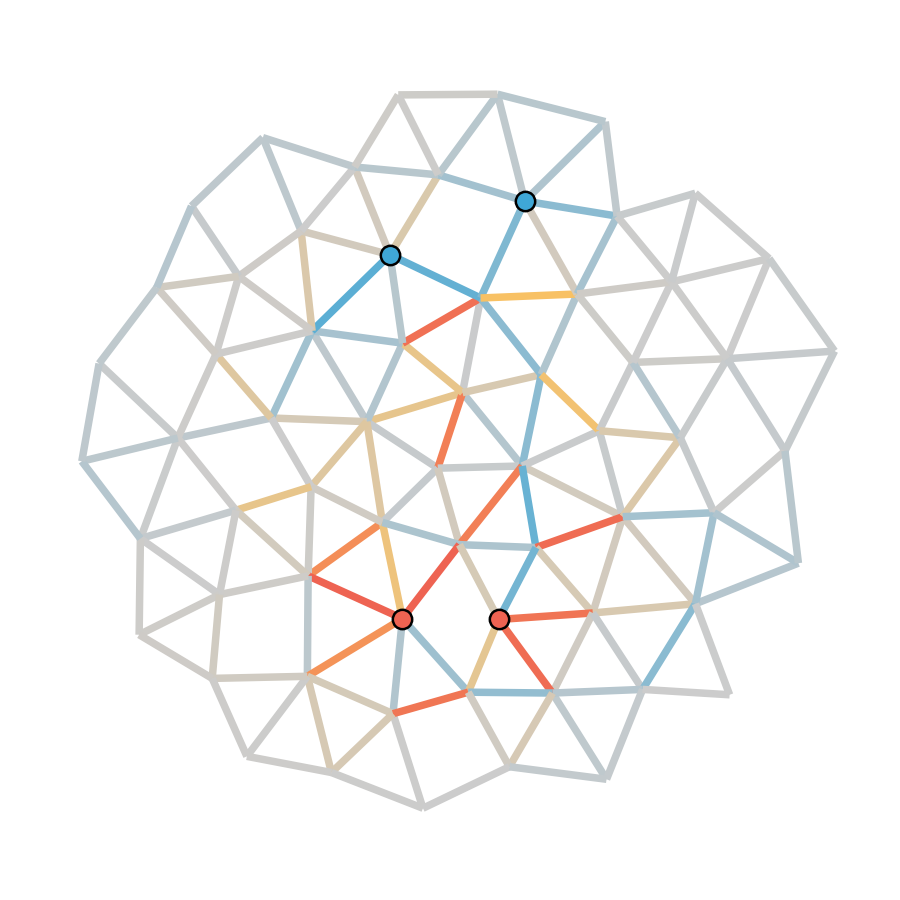

In [8]:
%matplotlib notebook

allo.reset_init() # reset network to its equilibrium state for visualization

cmap = continuous_cmap([pal['red'], pal['yellow'], np.array([0.8,0.8,0.8]),
                        pal['blue'], pal['purple']], [0,0.1,0.5,0.9,1])
allo.color_plot(cmap, vmin=0, vmax=2)